In [41]:
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import goatools
import operator

In [5]:
# extract the relevent tissue types
tissues = {}
inputFilename = '../data/Tissue_Name_Mappings.csv' # manually curated by Nico
inputFile = open(inputFilename)
atLine = 0
i = 0
for line in inputFile:
    i += 1
    line = line.rstrip() # remove newline at end of line
    supp_tissue_names = line.split(',')[1:]  # Names of tissues in supplementary file
    for name in supp_tissue_names:
        if name == '' or name == '\r\n':
            continue
        else:
            #term = term.split('\r\n')[0] 
            if i < 2:
                print name
                print str(int(name.split('(')[1].split(')')[0]))
            tissues[name] = int(name.split('(')[1].split(')')[0])
inputFile.close()


# extract the relevant GO terms
GOMap = {}
inputFilename = '../data/BTO_GO.csv'
inputFile = open(inputFilename)
atLine = 0
skipLines = 2
for line in inputFile:
    if atLine < skipLines:
        atLine += 1
        continue
    line = line.rstrip() # to avoid end of string in the last term
    str_list = line.split(',')[1:]
    tissue = str_list[0]

    if tissue in tissues:
        for term in str_list[1:]:
            if term == '' or term == '\r\n':
                continue
            else: 
                #term = term.split('\r\n')[0] 
                if term not in GOMap:
                    GOMap[term] = [tissue]    
                else:
                    GOMap[term].append(tissue)

inputFile.close()
print 'Number of tissues in BTO : ' + str(len(tissues))
print 'Number of GO terms       : ' + str(len(GOMap))


adipose tissue (16)
16
white adipose tissue (2)
2
Number of tissues in BTO : 39
Number of GO terms       : 1641


In [7]:
from goatools.associations import read_ncbi_gene2go
from goatools.base import download_ncbi_associations

def map_entrez_to_ensembl(path):
    dict = {}
    file = open(path)
    for line in file:
        vals = line.split('\t')
        ens_gene_id = vals[0]
        entrez_id = vals[2]
        dict[entrez_id] = ens_gene_id

    file.close()
    return dict

def get_ensembl_ids(go_process_id, entrez_to_ensembl):
    gene2go = '../data/gene2go' # gene2go = download_ncbi_associations()
    # taxids=[9606] means select only human.
    # TODO: ask Marinka if we should use EXP code for evidence!!
    go_to_entrez_ids_human = read_ncbi_gene2go(gene2go, taxids=[9606], go2geneids=True)
    """, evidence_set='EXP'"""

    entrez_ids = go_to_entrez_ids_human[GO_PROCESS_ID]
    # ensembl_ids = []
    # for ent_id in entrez_ids:
    #    ensembl_ids.append(entrez_to_ensembl[str(ent_id)])
    # print("{N} GO terms associated with human NCBI Entrez GeneIDs".format(N=len(go_to_entrez_ids_human)))
    #return ensembl_ids
    return entrez_ids



In [8]:
geneCounts = []
biomart_file_path = '../data/biomart_ensembl_to_entrez.txt'
path_to_rpkm_file = '../local_data/transcript_rpkm_top_10000_var.txt'
entrez_to_ensembl = map_entrez_to_ensembl(biomart_file_path)
for key in GOMap:
    GO_PROCESS_ID = key  # Biological Process ID in Gene Ontology
    ensembl_ids = get_ensembl_ids(GO_PROCESS_ID, entrez_to_ensembl)
    num_ensemble_ids = len(ensembl_ids)
    geneCounts.append(num_ensemble_ids)
    print key + ': # of Ensemble IDs: ', num_ensemble_ids

#gene_ids_ordered = []
#NUM_SAMPLES = 8555
#gene_features = np.empty((0, NUM_SAMPLES))

16439 GO terms associated with human NCBI Entrez GeneIDs
# of Ensemble IDs:  1
16439 GO terms associated with human NCBI Entrez GeneIDs
# of Ensemble IDs:  1
16439 GO terms associated with human NCBI Entrez GeneIDs
# of Ensemble IDs:  16
16440 GO terms associated with human NCBI Entrez GeneIDs
# of Ensemble IDs:  0
16440 GO terms associated with human NCBI Entrez GeneIDs
# of Ensemble IDs:  0


KeyboardInterrupt: 

In [8]:
biomart_file_path = '../data/biomart_ensembl_to_entrez.txt'
entrez_to_ensembl = map_entrez_to_ensembl(biomart_file_path)
gene2go = '../data/gene2go.txt' 

# taxids=[9606] means select only human.
go_to_entrez_ids_human = read_ncbi_gene2go(gene2go, taxids=[9606], go2geneids=True)
print("{N} GO terms associated with human NCBI Entrez GeneIDs".format(N=len(go_to_entrez_ids_human)))


16439 GO terms associated with human NCBI Entrez GeneIDs


In [25]:
# Get the GO process IDs from supplementary file
path_to_supplementary_file = '../data/Supplementary_Table_9_ng_3259_S10.csv'
inputFile = open(path_to_supplementary_file)
atLine = 0
skipLines = 2
i = 0
GO_PROCESS_ID_COUNTS = {}  # GO_PROCESS_ID_COUNTS['GO:0071373'] should eventually give the
                # number of ensembl genes that this GO term is associated with.
for line in inputFile:
    if atLine < skipLines:
        atLine += 1
        continue
    i += 1
    line = line.rstrip()
    fields = filter(None, line.split(',')[1:])  # Remove all empty strings from the list
    for id in fields[1:]:
        GO_PROCESS_ID_COUNTS[id] = 0

In [26]:
# Get number of ensembl IDs associated with each GO process
for id in GO_PROCESS_ID_COUNTS.keys():
    entrez_ids = go_to_entrez_ids_human[id]
    #print '# of Entrez IDs associated with ', id, ' = ', len(entrez_ids)
    ensembl_ids = []
    for ent_id in entrez_ids:
        if str(ent_id) in entrez_to_ensembl:
            ensembl_ids.append(entrez_to_ensembl[str(ent_id)])
    GO_PROCESS_ID_COUNTS[id] = len(ensembl_ids)

    #print '# of Ensembl IDs associated with ', id, ' = ', len(ensembl_ids)

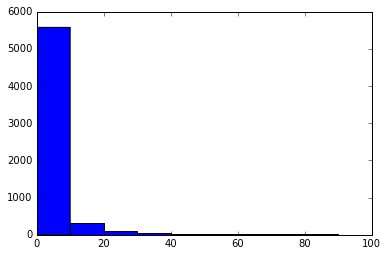

In [36]:
# Plot the histogram showing how many gene IDs that GO terms map to
plt.hist(GO_PROCESS_ID_COUNTS.values(), bins=range(0,110,10))
plt.show()

In [51]:
# Generate a sorted list of GO terms in order of how many genes the term is associated with
sorted_GO_terms = sorted(GO_PROCESS_ID_COUNTS.items(), key=operator.itemgetter(1), reverse=True)
outputFile = open('../data/GO_term_gene_counts.txt', 'w')
outputFile.write('GO Process ID' + '\t' + 'Num_Genes_In_Ensembl' + '\n')
for (GO_term, count) in sorted_GO_terms:
    outputFile.write(GO_term + '\t' + str(count) + '\n')